In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
import ct_projector.projector.cupy as ct_projector

In [3]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
spacing = np.array(spacing[::-1])

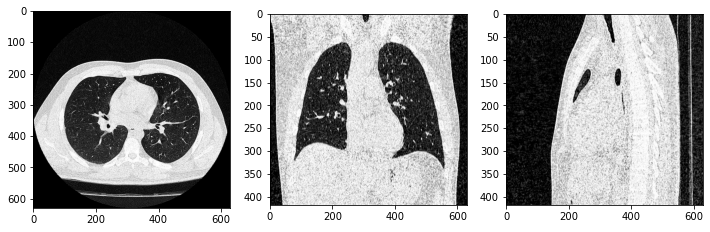

In [4]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [5]:
# setup the projector
projector = ct_projector.ct_projector()
projector.from_file('./projector.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = img.shape[1]
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 2
nu = 2048
nv = 3072
nx = 630
ny = 630
nz = 418
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 3000.0
dso = 2700.0
du = 0.25
dv = 0.25
off_u = 0
off_v = 0
geometry = <configparser.ConfigParser object at 0x7f3768e705e0>


In [6]:
# setup the positions of projections, let's do 0, 45, 90, and 135
angles = np.array([0, 45, 90, 135]) * np.pi / 180

srcs = np.array([projector.dso * np.cos(angles), 
                 projector.dso * np.sin(angles), 
                 [0] * len(angles)]).T

det_centers = np.array([(projector.dso - projector.dsd) * np.cos(angles), 
                        (projector.dso - projector.dsd) * np.sin(angles), 
                        [0] * len(angles)]).T

det_us = np.array([-np.sin(angles), np.cos(angles), [0] * len(angles)]).T
det_vs = np.zeros_like(det_us)
det_vs[:, 2] = 1

In [7]:
# very important: use np.copy('C') so that the arrays are saved in C order
cp.cuda.Device(0).use()
cuimg = cp.array(img, cp.float32, order='C')
cusrcs = cp.array(srcs, cp.float32, order='C')
cudet_centers = cp.array(det_centers, cp.float32, order='C')
cudet_us = cp.array(det_us, cp.float32, order='C')
cudet_vs = cp.array(det_vs, cp.float32 ,order='C')

In [8]:
# set which device to use
# projector.set_device(0)
# forward projection
cufp = projector.siddon_cone_fp_arbitrary(cuimg, cudet_centers, cudet_us, cudet_vs, cusrcs)
fp = cufp.get()

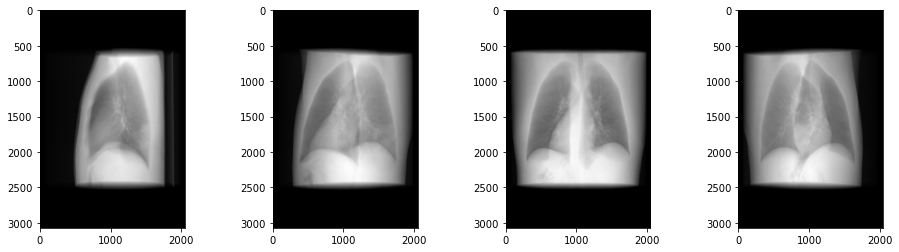

In [9]:
# show the projections
plt.figure(figsize = (16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(fp[0, i, ...], 'gray')

In [10]:
# backprojection: The siddon ray tracing has aliasing when backprojection. Need to be normalized
iangle = 2
cubp = projector.siddon_cone_bp_arbitrary(cp.copy(cufp[:, [iangle], ...], 'C'), 
                                         cudet_centers[[iangle]], 
                                         cudet_us[[iangle]],
                                         cudet_vs[[iangle]],
                                         cusrcs[[iangle]])
cubp_norm = projector.siddon_cone_bp_arbitrary(cp.ones(cufp[:, [iangle], ...].shape, cp.float32), 
                                              cudet_centers[[iangle]], 
                                              cudet_us[[iangle]], 
                                              cudet_vs[[iangle]], 
                                              cusrcs[[iangle]])
cubp = cubp / (cubp_norm + 1e-4)

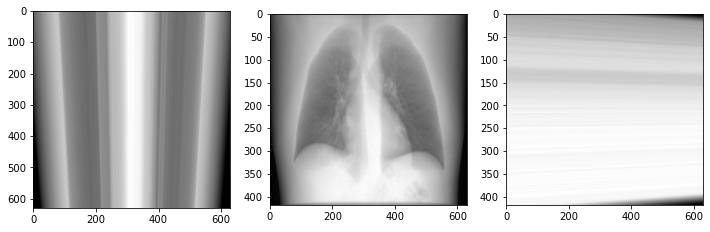

In [11]:
bp = cubp.get()

plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(bp[0, bp.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(bp[0, :, bp.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(bp[0, ..., bp.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])